In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [3]:
LMT_csv = Path("../ASD_Data/LMT_DATA.csv")

In [4]:
LMT_df = pd.read_csv(LMT_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [5]:
LMT_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-06-30,80.400002,81.269997,80.089996,80.970001,58.887226,1487100
2011-07-01,80.870003,82.010002,80.690002,81.970001,59.614498,1200900
2011-07-05,81.629997,81.629997,80.639999,80.970001,58.887226,1310400
2011-07-06,80.970001,81.930000,80.930000,81.620003,59.359955,2339400
2011-07-07,82.230003,82.230003,81.239998,81.360001,59.170860,1950500


In [6]:
LMT_df.sort_index(ascending=True, inplace=True)

In [8]:
LMT_df = LMT_df.rename(columns={'Close': 'Close'})
LMT_df = LMT_df[['Close']]
LMT_df

,Close
Date,
2011-06-30,80.970001
2011-07-01,81.970001
2011-07-05,80.970001
2011-07-06,81.620003
2011-07-07,81.360001
...,...
2021-06-24,377.730011
2021-06-25,382.010010
2021-06-28,380.070007


In [9]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [10]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(LMT_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[80.970001 81.970001 80.970001 81.620003 81.360001 80.510002 79.980003
  79.709999 79.669998 79.199997 78.370003 77.440002 78.400002 78.32
  80.160004 79.599998 79.300003 80.82     77.459999 75.290001 75.730003
  74.459999 73.68     73.559998 71.32     72.82     68.900002 70.879997
  66.870003 68.839996 69.120003 70.260002 70.690002 71.190002 69.379997
  69.389999 69.919998 71.879997 73.260002 72.040001 73.25     74.07
  74.099998 74.190002 73.050003 71.370003 71.220001 72.940002 71.940002
  71.57     72.239998 72.709999 73.580002 75.440002 76.029999 76.690002
  75.440002 72.650002 73.139999 72.089996 73.779999 74.269997 73.32
  72.489998 72.639999 71.160004 72.699997 72.489998 73.129997 74.
  75.75     76.32     76.129997 76.410004 75.989998 74.720001 75.980003
  75.470001 75.699997 77.400002 78.730003 78.889999 76.349998 75.650002
  75.43     75.900002 73.989998 74.519997 76.089996 76.519997 78.260002
  78.389999 76.949997 76.129997 77.419998 77.349998 77.849998 75.

In [11]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [12]:
y_train

array([[ 74.489998],
       [ 74.470001],
       [ 73.949997],
       ...,
       [304.799988],
       [302.839996],
       [302.600006]])

In [13]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [18]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 10s 304ms/step - loss: 0.0037
Epoch 2/20
15/15 [==============================] - 5s 318ms/step - loss: 0.0181
Epoch 3/20
15/15 [==============================] - 5s 325ms/step - loss: 0.0138
Epoch 4/20
15/15 [==============================] - 5s 328ms/step - loss: 0.0045
Epoch 5/20
15/15 [==============================] - 6s 369ms/step - loss: 0.0061
Epoch 6/20
15/15 [==============================] - 10s 700ms/step - loss: 0.0039
Epoch 7/20
15/15 [==============================] - 12s 813ms/step - loss: 0.0162
Epoch 8/20
15/15 [==============================] - 13s 865ms/step - loss: 0.0465
Epoch 9/20
15/15 [==============================] - 14s 909ms/step - loss: 0.0547
Epoch 10/20
15/15 [==============================] - 16s 1s/step - loss: 0.0289
Epoch 11/20
15/15 [==============================] - 14s 919ms/step - loss: 0.0076
Epoch 12/20
15/15 [==============================] - 14s 902ms/step - loss: 0.0139
Epoch 13/20
15/15 [=

In [19]:
model.evaluate(X_test, y_test, verbose=0)

0.00807915348559618

In [20]:
predicted = model.predict(X_test)

In [21]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [22]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [23]:
LMT_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = LMT_df.index[-len(real_prices): ])

LMT_actual_predicted.head()

,Actual,Predicted
Date,,
2017-08-28,302.799988,317.079498
2017-08-29,303.609985,317.288116
2017-08-30,308.140015,317.469086
2017-08-31,306.299988,317.768188
2017-09-01,305.390015,318.136658


In [24]:
LMT_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-24,377.329987,404.134369
2021-06-25,377.730011,403.547455
2021-06-28,382.010010,402.873199
2021-06-29,380.070007,402.260864
2021-06-30,373.420013,401.695709


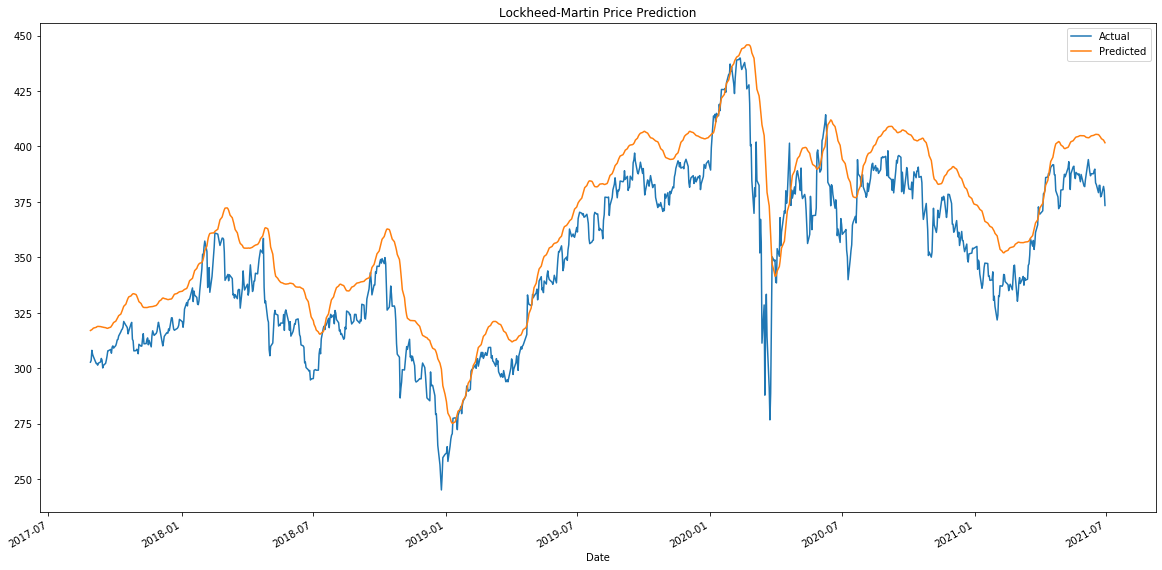

In [27]:
LMT_actual_predicted.plot(figsize=(20,10), title = "Lockheed-Martin Price Prediction")